<div align="right" style="text-align: right"><i>Peter Norvig<br>2017</i></div>

# Gesture Typing 


Typing quickly and accurately on a smartphone screen is hard! One invention to make it easier is **gesture typing**, in which your finger can trace a **path** consisting of letter-to-letter **segments**. When you lift your finger the path (and the word) is complete. Below we see a path for the word "HELLO." Note that the path is imprecise; it didn't quite hit the "L", but the word was recognized anyways, because "HELLO" is a known word, whereas "HEKKO", "HWERKO", etc., are not.

<img src="http://norvig.com/gesture.png">


My colleague [Nicolas Schank](https://www.linkedin.com/in/nschank/) examined (and answered) the question of what word has the longest path length. I mentioned this to [**Shumin Zhai**](http://www.shuminzhai.com/), the pioneer of gesture typing, and between the three of us we expanded the list of questions:

 1. What words have the longest **path length**?
 2. What is the keyboard's **average segment length**, over a typical typing work load?
 3. Is there a better keyboard layout to **minimize** the average segment length?
 4. Is there a better keyboard layout to minimize **word confusion** between paths (e.g confusing "HELLO" and "JELLO")? 
 5. Is there a better keyboard layout to maximize overall user **satisfaction**?

We can answer each of these questions, but first, let's get a rough idea for of the vocabulary of concepts we will need to model.

# Main Concepts

* **Letter**: We'll deal with the letters A-Z, and not worry about the other keys on the keyboard.
* **Words**: We will need a list of allowable words (in order to find the one with the longest path).
* **Path**: A path connects the letters in a word. In the picture above the path is curved, but a shortest distance between two points is a straight line, so we need only deal with straight line segments.
* **Segment**: A path consists of segments: the "H to E" segment followed by "E to L", etc.
* **Keyboard**: We'll need to know the **location** of each letter on the keyboard (we consider only letters, not the numbers and other symbols).
* **Point**: A location is a **point** in two-dimensional space (we assume keyboards are flat).
* **Distance**: We need to know the distance between two ends of a segment. By convention the distance between adjacent keys is 1.
* **Path length**: The length of a path is the sum of the lengths of the segments that make up the path.
* **Work Load**: The list of words doesn't say which ones are common and which are rare. We'll need a corpus of typical text to represent a work load.
* **Confusion**: We need some measure of *whether* (or perhaps *to what degree*) the paths for two words can be confused with each other.
* **Satisfaction**: This is a very difficult concept to define.  A user will be more satisfied with a keyboard if it allows for fast, accurate typing, and if it gives the user a feeling of mastery, not frustration.

## Implementation of Main Concepts

First the necessary `import` statements:

In [1]:
from statistics import mean
from typing import Set, List, Counter, Dict, Iterator, Callable, Collection
import matplotlib.pyplot as plt
import math
import random 
import re

Here are implementation choices for most of the concepts above (we'll get to path length, confusion, and satisfaction later).

In [2]:
Letter  = str # A one-character string like 'A'
Word    = str # A multi-character string like 'HELLO'
Path    = str # We can also use 'HELLO' to represent a path from H to E to L to L to O.
Segment = str # The segment from 'H' to 'E' can be represented by the string 'HE'
    
class Keyboard(dict):
    """A keyboard is a {letter: location} mapping, e.g. {'Q': Point(0, 0), 'A': Point(0.5, 1), ...}."""

class Point(complex):
    """A point in the (x, y) plane."""
    # We provide propertities to access the `x` and `y` components (instead of `real` and `imag`).
    x = property(lambda p: p.real)
    y = property(lambda p: p.imag)

def distance(A: Point, B: Point) -> float:
    """The distance between two points."""
    return abs(A - B)

class Workload(Counter): 
    """For each segment, how many times do we type it? E.g., {'HE': 123, ...}"""

The following helper function makes it easier to define a keyboard:

In [3]:
def keyboard(*rows: str, xscale=1/2, yscale=1) -> Dict[Letter, Point]:
    """Create a Keyboard from several rows of letter-and-blank characters."""
    return Keyboard({ch: Point(x * xscale, y * yscale) 
                     for (y, row) in enumerate(rows, 1)
                     for (x, ch) in enumerate(row, 1)
                     if ch != ' '})

In [4]:
QWERTY = keyboard('Q W E R T Y U I O P',
                  ' A S D F G H J K L ',
                  '   Z X C V B N M   ')

Since the "Q" row of the keyboard is offset by a half-key from the "A" and "Z" rows, I use a space to move over by a half-key, and set `xscale=1/2` by default, to make this work. If you want a different layout you can use different xscale and yscale factors. 

## Computing Path Length

Now let's figure out the path length for a word: the sum of the lengths of segments between letters.  So the path length for `'WORD'` would be the sum of the segment lengths for `'WO'` plus `'OR'` plus `'RD'`:

In [5]:
W, O, R, D = QWERTY['W'], QWERTY['O'], QWERTY['R'], QWERTY['D'], 
distance(W, O) + distance(O, R) + distance(R, D)

13.118033988749895

Let's make a function to compute this:

In [6]:
def path_length(path: Path, kbd=QWERTY) -> float:
    """The total path length for a word: the sum of the segment lengths."""
    return sum(distance(kbd[path[i]], kbd[path[i + 1]])
               for i in range(len(path) - 1))

In [7]:
path_length('WORD')

13.118033988749895

Is that correct? Let's check with a simpler example that we know the answer to:

In [8]:
assert path_length('TO') == 4

The **O** is four keys to the right of the **T**, on the same row, so the distance between them is 4.

Here's another one that you can verify on your own:

In [9]:
assert path_length('TYPEWRITER') == 1 + 4 + 7 + 1 + 2 + 4 + 3 + 2 + 1 == 25

Question 1: Longest Path Length?
===

To know what the longest word is, we'll have to know what the allowable words are. The so-called TWL06 word list gives all the words that are legal in the game of Scrabble; that seems like a reasonable list (although it omits proper nouns). Here's how to load a copy:

In [10]:
! [ -e TWL06.txt ] || curl -O http://norvig.com/ngrams/TWL06.txt
    
WORDS = set(open('TWL06.txt').read().split())

In [11]:
len(WORDS)

178691

That's a lot of words; which one has the longest path?

In [12]:
max(WORDS, key=path_length)

'PALEOMAGNETISMS'

And the ten longest paths? 

In [13]:
def top(n, sequence, key) -> list:
    """The top n elements of sequence, according to their `key(x)` score."""
    return Counter({x: key(x) for x in sequence}).most_common(n)
              
top(10, WORDS, key=path_length)

[('PALEOMAGNETISMS', 72.18390711071285),
 ('ANTIQUARIANISMS', 70.04356056276728),
 ('ELECTROANALYSIS', 69.90684706336143),
 ('ANTIAPHRODISIAC', 69.87108953956316),
 ('PARLIAMENTARIAN', 69.26190447267197),
 ('BLEPHAROSPASMS', 68.93838086646086),
 ('BIDIALECTALISMS', 68.6325692947858),
 ('PALEOGEOGRAPHIC', 67.63572577827519),
 ('SPERMATOZOANS', 67.5515501604518),
 ('APOCALYPTICISMS', 67.103335642663)]

Very long words tend to have long path lengths.  But what words have the highest **ratio**
of path length to word length? 

In [14]:
top(10, WORDS, key=lambda word: path_length(word, QWERTY) / len(word))

[('PALAPA', 6.945977358822589),
 ('PAPAL', 6.735172830587106),
 ('PAPA', 6.418966038233884),
 ('JALAPS', 6.354165726587104),
 ('SLAPS', 6.224998871904525),
 ('KAMALA', 6.1903559372884915),
 ('LAPELS', 6.189182433882466),
 ('PAPS', 6.170903935958617),
 ('HALALA', 6.166666666666667),
 ('SPALE', 6.140293515701115)]

I decided to measure word length by number of letters; an alternative could be number of segments.

# Question 2: Average Segment Length on Work Load?

What is the average segment length for a typical typing work load? To answer that, we need to know what a typical work load is. We will read a file of "typical" text, and count how many times each segment is used. A `Workload` is a `Counter` of the form `{segment: count, ...},` e.g. `{'HE': 123}`, where each key is a two-letter string (or **bigram**) representing a segment, and each value is the number of times that segment appears in the workload.  *Note:* The function `bigrams` uses some `re` trickiness: `([A-Z][A-Z])` means a group of two consecutive letters. But if I only looked for that, then in the text `'FOUR'` I would find `['FO', 'UR']`. So I use the `?=` operator, which says to check for a match, but don't consume the matched characters. So I can find `['FO', 'OU', 'UR']`, which is what I want.

In [15]:
def bigrams(text) -> List[str]: 
    """All the two-letter sequences in a text (including overlapping ones)."""
    return re.findall(r'(?=([A-Z][A-Z]))', text)

Let's see what a workload looks like for a tiny text:

In [16]:
Workload(bigrams('THE SHOT -- GOOOOOOOOOAL!'))

Workload({'OO': 8,
          'TH': 1,
          'HE': 1,
          'SH': 1,
          'HO': 1,
          'OT': 1,
          'GO': 1,
          'OA': 1,
          'AL': 1})

I happened to have a file of about a megabyte of random text, `smaller.txt`; that should work fine as a typical work load:

In [17]:
! [ -e smaller.txt ] || curl -O http://norvig.com/ngrams/smaller.txt
    
WORKLOAD = Workload(bigrams(open('smaller.txt').read().upper()))

Let's peek at the most common segments:

In [18]:
WORKLOAD.most_common(10)

[('TH', 23731),
 ('HE', 21395),
 ('IN', 14162),
 ('ER', 13365),
 ('AN', 12488),
 ('RE', 10998),
 ('ON', 10314),
 ('ND', 9241),
 ('EN', 8786),
 ('AT', 8617)]

The most popular segments are `TH` and `HE`. 

We can compute the average segment length on our workload for the QWERTY keyboard:

In [19]:
def workload_average_length(kbd, workload=WORKLOAD) -> float:
    """The average segment length over a workload of segments."""
    return sum(distance(kbd[A], kbd[B]) * workload[A+B]
               for (A, B) in workload) / sum(workload.values())

In [20]:
workload_average_length(QWERTY)

3.233309780212763

So, on average, your finger has to travel a little over 3 keys from one letter to the next over a typical workload.

## Aside: Visualizing a Keyboard

I'll define `plot_kbd` to plot the letters in a keyboard at their (x, y) points, draw a circle around each letter, and give the metric on some scorer function (by default, the workload average length):

In [21]:
def plot_kbd(kbd: Keyboard, scorer=workload_average_length) -> None:
    """Plot the keyboard."""
    plt.plot([-0.5, 9.5], [0.5, 0.5], 'w-') # Dummy white line to make key size the same in each plot.
    plt.rcParams.update({'font.size': 14})
    for L in kbd:
        plot_key(kbd[L].x, -kbd[L].y, letter=L)
    plt.axis('equal'); plt.xticks(()); plt.yticks(())
    plt.xlabel(f'{scorer.__name__}: {scorer(kbd):.2f}')
    plt.show()

def plot_key(x, y, letter='') -> None:
    """Plot a circle with center (x, y) and given letter."""
    plt.gca().add_patch(plt.Circle((x, y), 0.46, fill=False))
    plt.annotate(letter, (x-0.17, y-0.12))


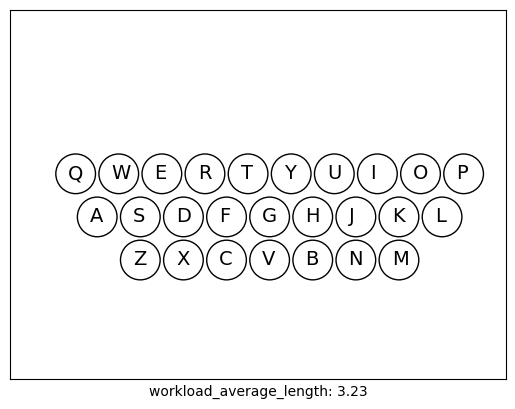

In [22]:
plot_kbd(QWERTY)

# Question 3: Minimize Average Segment Length over a Workload?

Now for a much harder question: can we find a different keyboard layout that has a smaller average segment length over the workload? First, let's note that there are two ways to modify a keyboard:  

* **Change the key caps**: For example, swap the "Q" with the "W".
* **Change the key locations**: For example,  layout the keys in 4 rows instead of 3. 

Let's start by limiting ourselves to just swapping letters.  

This is an **optimization** problem.  There are many permutations of letters; too many to try them all. To be precise, there are 26! (26 factorial) permutations, which is about 10<sup>26</sup> (fun fact: 24, 25 and 26 are the only integers for which n! &approx; 10<sup>n</sup>).  If we can't try them all, we need some way to sample the configurations, trying to make progress towards a better one. Again, we'll try the simplest thing that could possibly work: 

  1. Pick two keys at random.
  2. Swap them.
  3. If that gives a better (lower) workload total, keep them that way.
  4. If not, swap back.
  5. Repeat this for a given number of times, say 1000.

(Below I make `scorer` be a parameter of `improved`, so that later we can minimize something else other than `workload_average_length`.)

In [23]:
def improved(original_kbd, swaps=1000, scorer=workload_average_length) -> Keyboard:
    """Minimize scorer(kbd) by swapping keys, keeping the swaps that improve (minimize) the score."""
    kbd = Keyboard(original_kbd); 
    score = scorer(kbd)
    letters = list(kbd)
    for _ in range(swaps):
        A, B = random.sample(letters, 2)   # Step 1: pick two keys
        swap(kbd, A, B)                    # Step 2: swap them
        score2 = scorer(kbd)
        if score2 < score:                 # Step 3: If better, keep them
            score = score2                 # (and record the new best total)
        else:
            swap(kbd, A, B)                # Step 4: swap back if not better
    return kbd

def swap(kbd, A, B): kbd[A], kbd[B] = kbd[B], kbd[A]

Let's see how well we can do:

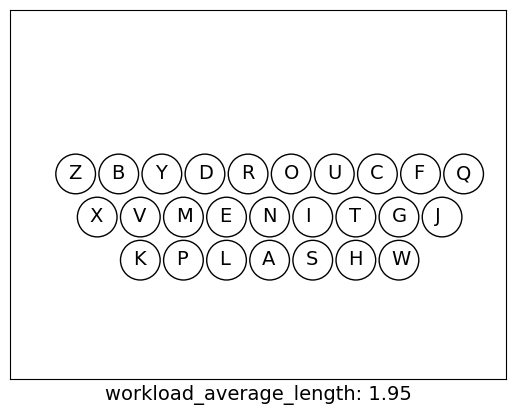

In [24]:
plot_kbd(improved(QWERTY))

That's a pretty good improvement! We decreased the average segment length by about a third. 

# Question 4: Minimize word path confusions?

When can one word be confused with another?  When their paths are similar (which means that their corresponding letters are in similar locations). For example, on a QWERTY keyboard, the paths for "HELLO" and "JELLO" are similar, because **H** and **J** are adjacent, and the other letters are the same.

<img src="http://norvig.com/gesture.png">

We'd like to know, for a given keyboard, how confusing is it? How many words have paths on the keyboard that can be confused for other words? We have our work cut out for us:

1. Determine what letters could be confused for what other letters (for example, `H` and `J`).
2. Determine what words/paths can be confused (for example `HELLO` and `JELLO`).
3. Invent some metric for the overall confusingness of a keyboard. 
4. Try to find less-confusing keyboards.

One concern is that `WORDS` has 178,691 words, many of which are quite unusual, so there might be too many confusions with strange words. My zeroth step is reading in a smaller word set, with only 3,614 of the most common words:

In [25]:
! [ -e words.js ] || curl -O https://xkcd.com/simplewriter/words.js
    
COMMON = set(re.findall('[A-Z]+', open('words.js').read().upper()))
len(COMMON)

3614

## Letter Confusions

What letters can each letter be confused with? I'll say that any key within a distance of 1.5 units on the keyboard is in the **neighborhood**, and thus a potential confusion:

In [26]:
def neighborhood(kbd, radius=1.5) -> Dict[Letter, str]:
    """Build a dict of {Letter: neighborhoodLetters}, e.g. {'Q':'AQW', ...}."""
    return {A: cat(sorted(B for B in kbd if distance(kbd[A], kbd[B]) <= radius))
            for A in kbd}

cat = ''.join  ## Function to join letters (or strings) into one string

In [27]:
QWERTY_neighborhood = neighborhood(QWERTY) 
QWERTY_neighborhood

{'Q': 'AQW',
 'W': 'AEQSW',
 'E': 'DERSW',
 'R': 'DEFRT',
 'T': 'FGRTY',
 'Y': 'GHTUY',
 'U': 'HIJUY',
 'I': 'IJKOU',
 'O': 'IKLOP',
 'P': 'LOP',
 'A': 'AQSWZ',
 'S': 'ADESWXZ',
 'D': 'CDEFRSXZ',
 'F': 'CDFGRTVX',
 'G': 'BCFGHTVY',
 'H': 'BGHJNUVY',
 'J': 'BHIJKMNU',
 'K': 'IJKLMNO',
 'L': 'KLMOP',
 'Z': 'ADSXZ',
 'X': 'CDFSXZ',
 'C': 'CDFGVX',
 'V': 'BCFGHV',
 'B': 'BGHJNV',
 'N': 'BHJKMN',
 'M': 'JKLMN'}

We see, for example, that **Q**, off in the corner, has only **A**, **W**, and itself in its neighborhood, while **G**, in the middle of the keyboard, has 8 letters in its neighborhood. 

## Word Confusions

Given a path, what words can it be confused for? Consider each of the letters in the word "HELLO," and all the possible choices for neighborhood of each letter:

In [28]:
[QWERTY_neighborhood[L] for L in 'HELLO']

['BGHJNUVY', 'DERSW', 'KLMOP', 'KLMOP', 'IKLOP']

These are five columns of letters, and if we pick one letter from each column, we get a path that is formed by letters that are each confusions of letters in the original word, and so the whole path is a confusion for the original word.  So "JELLO" is a confusion for "HELLO", as would be "BDKKI" except that it is not an actual word.

If we pick one letter from each column, in all possible ways, we could end up with a **lot** of paths for long words. Consider

In [29]:
[QWERTY_neighborhood[L] for L in 'PALEOMAGNETISMS']

['LOP',
 'AQSWZ',
 'KLMOP',
 'DERSW',
 'IKLOP',
 'JKLMN',
 'AQSWZ',
 'BCFGHTVY',
 'BHJKMN',
 'DERSW',
 'FGRTY',
 'IJKOU',
 'ADESWXZ',
 'JKLMN',
 'ADESWXZ']

In [30]:
math.prod(map(len, _))

68906250000

That's almost 70 billion paths for PALEOMAGNETISMS. But most of the paths make no sense. For example, if we choose 'P' for the first letter, then only 'A' can be the second letter, neither 'PQ', 'PS', 'PW', nor 'PZ' start any word in the COMMON dictionary. So I'll create a set of all the PREFIXES of all the common words:

In [31]:
def prefixes(words: Collection[Word]) -> Set[str]:
    """Return a set of prefixes (1 or more leading characters) of this collection of words."""
    return {word[:i] for word in words for i in range(1, len(word) + 1)}

PREFIXES = prefixes(COMMON)

Now `confusions` will yield all paths that are confusions of the word:

In [32]:
def confusions(word, path='', neighborhood=QWERTY_neighborhood, prefixes=PREFIXES, words=COMMON) -> Iterator[Path]:
    """All valid words whose paths could be confused with the path for this word."""
    if len(path) < len(word):
        for L in neighborhood[word[len(path)]]:
            if path + L in prefixes:
                yield from confusions(word, path + L, neighborhood, prefixes, words)
    elif path in words and path != word:
        yield path

For example:

In [33]:
set(confusions('TESTING'))

{'FEARING', 'GRAYING', 'GREYING', 'RESTING', 'TEARING'}

In [34]:
set(confusions('THREE'))

{'GUESS', 'THERE', 'THESE', 'THREW'}

## Confusingness score of a Keyboard 

One metric for confusingness is the percentage of common words that are confused with any other common word:

In [35]:
def confusingness(kbd, words=COMMON) -> float:
    """The proportion of `words` that are confused with at least one other word on this keyboard."""
    neighbors = neighborhood(kbd)
    return mean(any(confusions(word, neighborhood=neighbors)) for word in COMMON)

In [36]:
confusingness(QWERTY)

0.5398450470392916

Almost 54% of the common words are confusable on the QWERTY keyboard.

## Aside: Visualizing Paths on a Keyboard

It would be nice to see potentially confusable word paths on a keyboard.
I'll define `plot_with_paths`:



In [37]:
def plot_with_paths(kbd: Keyboard, paths: List[Path]) -> None:
    """Plot the kbd and paths."""
    for path in paths:
        Xs = [kbd[L].x for L in path]
        Ys = [-kbd[L].y for L in path]
        plt.plot(Xs, Ys, '-o')
    plot_kbd(kbd)

Let's see how it works on three similar paths:

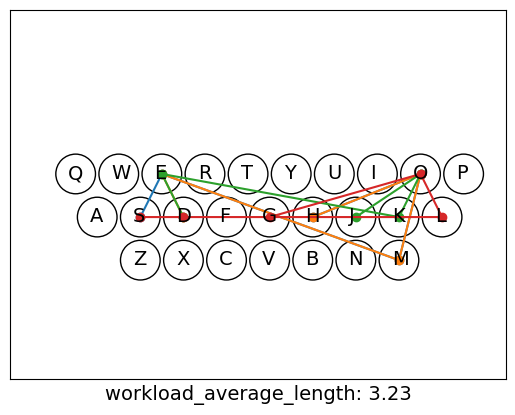

In [38]:
plot_with_paths(QWERTY, paths=['HOMES', 'HOMED', 'JOKED', 'GOLDS'])

 OK, we're on the right track, but I see three problems, which I think I can solve: 

- The letters are obscured.  Solution: offset paths away from the center.
- When the paths are similar (HOMES and HOMED), they are mostly on top of each other.  Solution: offset each path away from the center in a different direction.
- There is no indication what direction the path is going in. Solution: put a different marker on the start position of each path.

In [39]:
def plot_with_paths(kbd: Keyboard, paths: List[Path]) -> None:
    """Plot the kbd and paths."""
    K = 1/5 # This value makes the plot look about right
    offsets = [Point(-K, -K), Point(-K, +K),  Point(K, +K), Point(K, -K)]
    for (i, path) in enumerate(paths):
        Xs = [kbd[L].x + offsets[i % 4].x for L in path]
        Ys = [-kbd[L].y + offsets[i % 4].y for L in path]
        plt.plot(Xs, Ys, '-o')
        plt.plot(Xs[:1], Ys[:1], 'ks')
    plot_kbd(kbd)

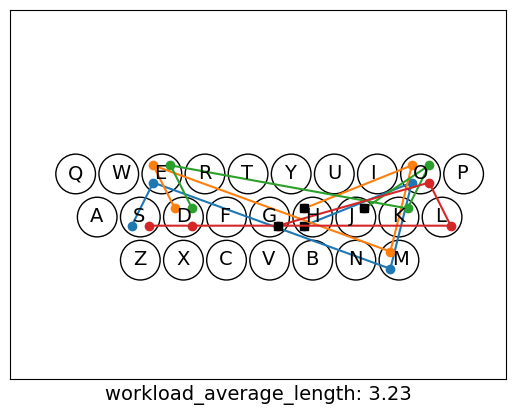

In [40]:
plot_with_paths(QWERTY, paths=['HOMES', 'HOMED', 'JOKED', 'GOLDS'])

That still looks busy, but it is better.

## Minimize word path confusions

Consider this:

In [41]:
%time confusingness(QWERTY)

CPU times: user 28.7 ms, sys: 1.07 ms, total: 29.8 ms
Wall time: 29.4 ms


0.5398450470392916

In [42]:
%time workload_average_length(QWERTY)

CPU times: user 93 μs, sys: 1 μs, total: 94 μs
Wall time: 93.9 μs


3.233309780212763

Computing `confusingness` takes a lot longer than computing `workload_average_length`, so if we want to use `confusingness` as a scoring function, we will have to settle for fewer swaps:

CPU times: user 5.04 s, sys: 13.6 ms, total: 5.05 s
Wall time: 5.05 s


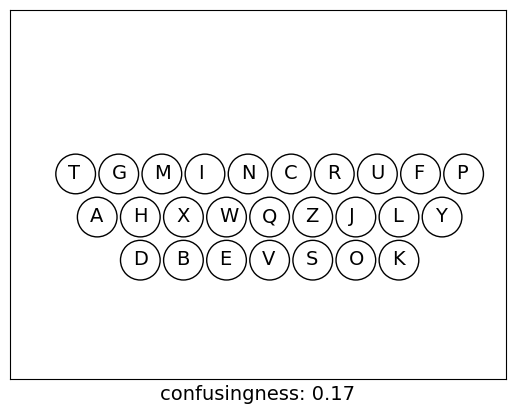

In [43]:
%time KBD2 = improved(QWERTY, swaps=200, scorer=confusingness)
plot_kbd(KBD2, scorer=confusingness)

This significantly reduced confusingness, which previously was about 0.54. 

# Question 5: Maximize User Satisfaction?

What makes a keyboard satisfying for the user? I don't know, but workload average and confusingness seem like two important factors. For now I'll just multiply them together, and note that  since `improve` works by minimizing a scoring function, we'll define `dissatisfaction` and minimize it:

In [44]:
def dissatisfaction(kbd, scale=50) -> float:
    """A combination of workload average and confusingness, scaled."""
    # The scale factor is arbitrary; it keeps the score in the range from 10 to 100 on most keyboards.
    return scale * workload_average_length(kbd) * confusingness(kbd)

In [45]:
dissatisfaction(QWERTY)

87.27431351957803

CPU times: user 7.36 s, sys: 18.9 ms, total: 7.38 s
Wall time: 7.41 s


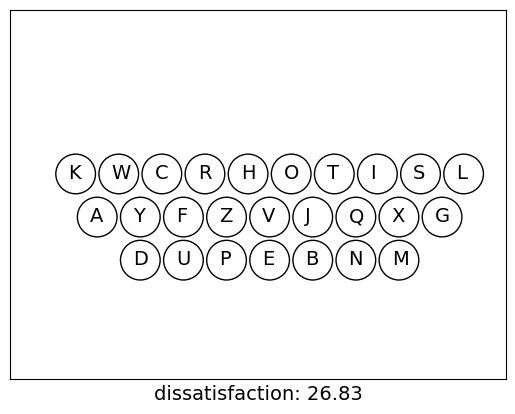

In [46]:
%time KBD3 = improved(QWERTY, swaps=300, scorer=dissatisfaction)
plot_kbd(KBD3, scorer=dissatisfaction)

Success!  We were in fact able to make progress on the combined metric, improving from about 87 dissatisfaction to about 27.

# Layout with Keys in Different Configuration

Now let's allow keys  to be in different physical locations.  We'll examine four possible physical layouts: the 3-row QWERTY keyboard, a 4-row and a 5-row keyboard, and the  [Keybee keyboard](http://keybee.it/) (shown below), which uses 4 rows of keys interleaved in a hexagonal layout (although we will still draw the keys as circles):

<img src="http://keybee.it/img/phones/theme_002.png" alt="Keybee keyboard" width=300>

In [47]:
keyboards = {
    'QWERTY':
    QWERTY,
    '4-by-7':
    keyboard(' A B C D E F ',
             'G H I J K L M',
             ' N O P Q R S ',
             'T U V W X Y Z'),
    '5-by-6':
    keyboard(' A B C D E ',
             'F G H I J K',
             'L M N O P Q',
             ' R S T U V ',
             '  W X Y Z  '),
    'keybee':
    keyboard(' Q W C ',
             'J U I K',
             ' F H N ',
             'Z O T G',
             ' R _ Y ',
             'B E S V',
             ' P A M ',
             'X L D  ', 
             xscale=math.sqrt(3)/2, yscale=0.50)}

Here is a function to improve and plot a collection of keyboards:

In [48]:
def plot_improved_kbds(keyboards, swaps=3000, scorer=workload_average_length) -> None:
    """Iterate through a dict of {name: kbd} pairs, improving and plotting each kbd."""
    for name, kbd in keyboards.items():
        plot_kbd(improved(kbd, swaps=swaps, scorer=scorer), scorer=scorer)

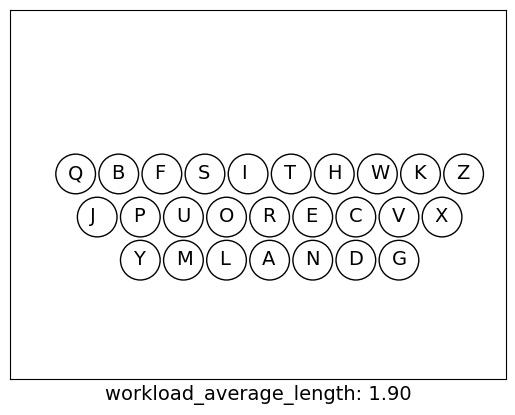

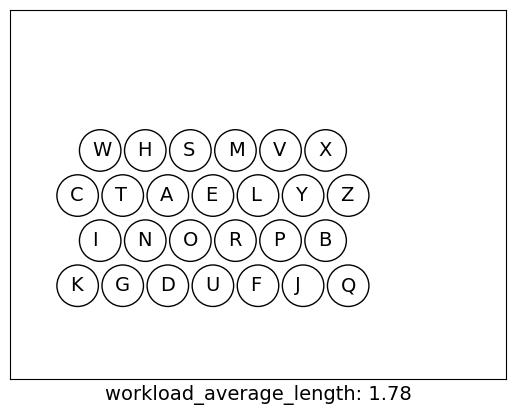

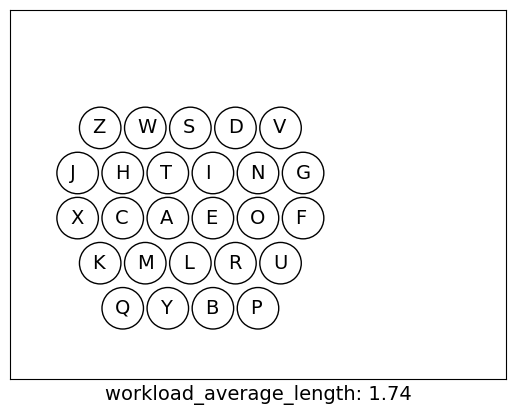

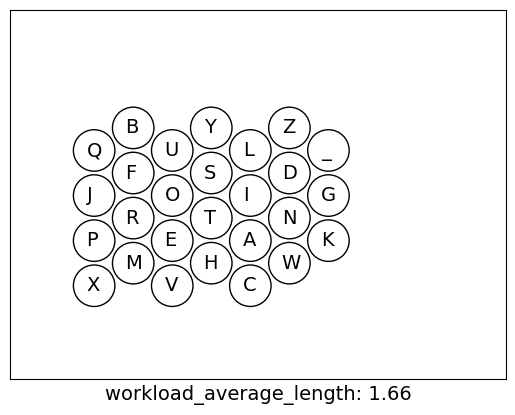

In [49]:
plot_improved_kbds(keyboards, scorer=workload_average_length)

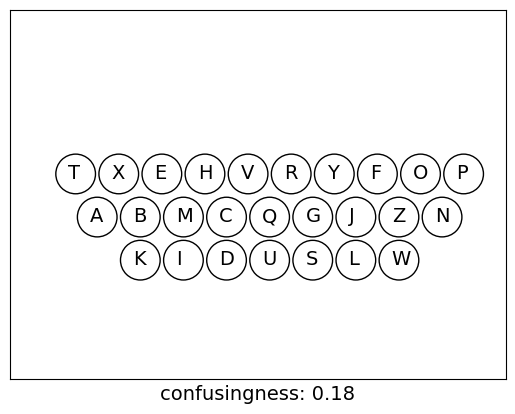

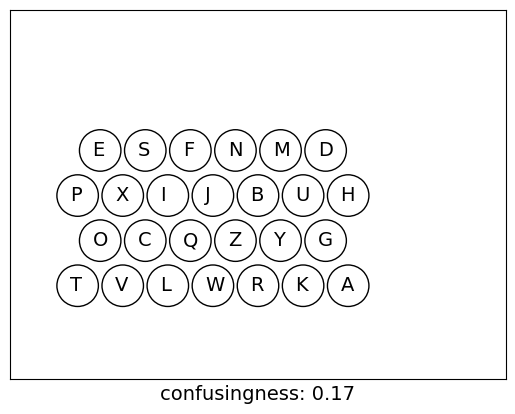

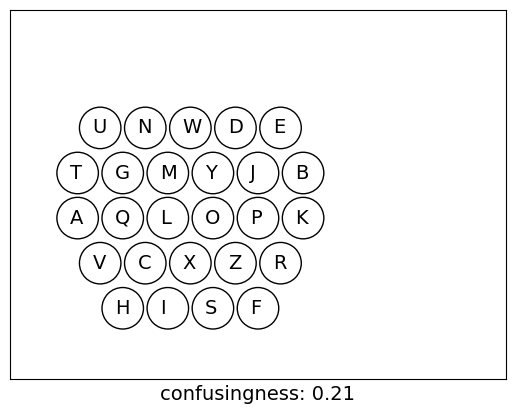

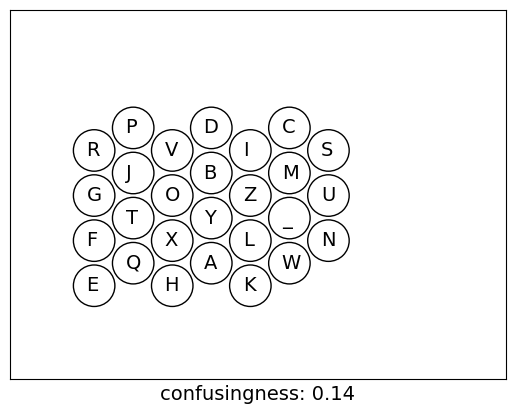

In [50]:
plot_improved_kbds(keyboards, swaps=200, scorer=confusingness)

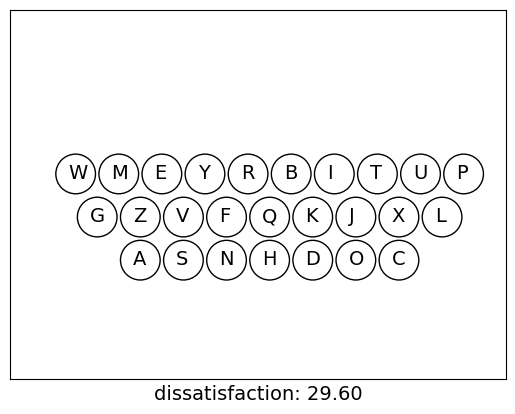

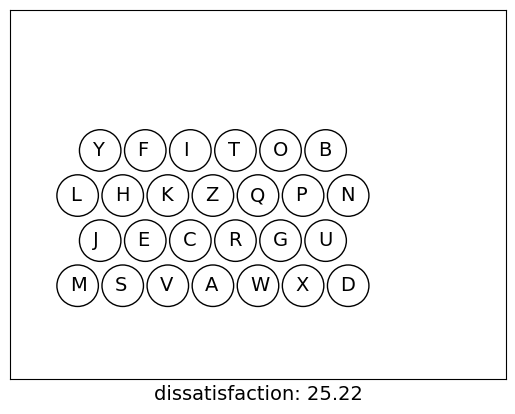

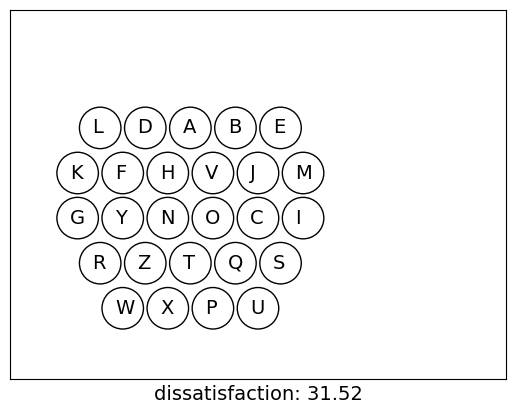

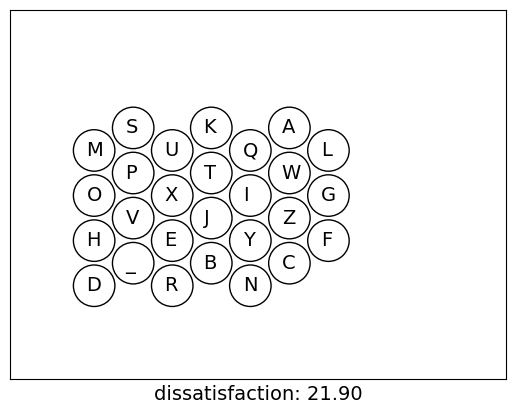

In [51]:
plot_improved_kbds(keyboards, swaps=200, scorer=dissatisfaction)

Here's a table to more compactly see what is going on. For each of the four keyboard shapes I call `improved` to maximize each of the three scorer functions, and then report the final score on each of the three metrics.


In [52]:
def improved_kbds_table(keyboards, swaps=3000, 
                        scorers=(workload_average_length, confusingness, dissatisfaction),
                        header='Keybd  Scorer swaps | work  conf  diss',
                        bar=   '-----  ------ ----- + ----  ----  ----') -> None:
    """Iterate through a dict of {name: kbd} pairs, improving and plotting each kbd."""
    print(bar)
    print(header)
    for scorer in scorers:
        print(bar)
        for name, original_kbd in keyboards.items():
            N = (swaps if scorer is workload_average_length else swaps // 10)
            kbd = improved(original_kbd, N, scorer=scorer)
            def score(fn) -> str: return f'{fn(kbd):5.2f} '
            print(f'{name:7} {scorer.__name__[:4]} {N:6d} |{cat(map(score, scorers))}')

%time improved_kbds_table(keyboards)

-----  ------ ----- + ----  ----  ----
Keybd  Scorer swaps | work  conf  diss
-----  ------ ----- + ----  ----  ----
QWERTY  work   3000 | 1.90  0.69 65.17 
4-by-7  work   3000 | 1.78  0.65 57.59 
5-by-6  work   3000 | 1.77  0.70 62.02 
keybee  work   3000 | 1.63  0.66 54.17 
-----  ------ ----- + ----  ----  ----
QWERTY  conf    300 | 3.69  0.14 26.51 
4-by-7  conf    300 | 2.96  0.15 21.80 
5-by-6  conf    300 | 2.69  0.21 28.00 
keybee  conf    300 | 2.58  0.12 15.90 
-----  ------ ----- + ----  ----  ----
QWERTY  diss    300 | 3.39  0.18 30.63 
4-by-7  diss    300 | 2.83  0.16 22.23 
5-by-6  diss    300 | 2.64  0.20 26.07 
keybee  diss    300 | 2.65  0.14 19.04 
CPU times: user 1min, sys: 175 ms, total: 1min
Wall time: 1min


So the more compact keyboards with a smaller diameter perform  better than `QWERTY`. The improved Keybee is the best, but maybe that is because the keys are slightly closer together, not because of the layout.

# Summary
  
1. What words have the longest path length? <br>**Answer**: "PALEOMAGNETISMS". Also, "PALAPA" has the highest ratio of path length to word length.
2. What is the average segment length, over a typical typing work load? <br>**Answer**: 3.2 units, for the QWERTY keyboard, on our sample workload.
3. Is there a better keyboard layout to minimize the average segment length?  <br>**Answer**: Yes, many layouts at around 1.9 on QWERTY and around 1.6 to 1.8 on different-shaped keyboards.
4. Is there a better keyboard layout to minimize word confusion between paths? <br>**Answer**: On QWERTY, 54% of the words in a small dictionary have at least one possible confusion; other layouts get down to about 12%. 
5. Is there a better keyboard layout to maximize overall user satisfaction? <br>**Answer**: I defined a combined metric of dissatisfaction on
which QWERTY has a score of 87, and was able to get that down to somehwere in the teens (on different-shaped keyboards). There are no doubt better metrics, and better keyboards to be found.
 

# Going Beyond

Now it is your turn to answer the open questions, or make up some questions of your own.  Good luck and have fun! Here are a few ideas to get you started:

* There are many heuristic optimization techniques such as
[beam search](http://en.wikipedia.org/wiki/Beam_search) or [genetic algorithms](http://en.wikipedia.org/wiki/Genetic_algorithm)  or [ant colony optimization](http://en.wikipedia.org/wiki/Ant_colony_optimization_algorithms). Is there a better optimizer than our `improved` function?
* The code in this notebook emphasizes clarity, not efficiency.  Can you modify the code (or perhaps port it to another language) and make it twice as efficient? 10 times? 100 times?
* What other factors do you think are important to user satisfaction with a keyboard.  Can you measure them?
* Consider the 8 paths below. They all start at 'P', move in a straight line to 'T', and then go to 'S', but they all make different stops along the top row. In other words, the paths all trace exacty the same lines, so they are very confusing, but our definition of  `confusions`says that a 4-letter word can never be a confusion of a 5-letter word, and that "POTS" and "PUTS" are not confusions, because the "O" is 2 units away from the "U".  Can you think of a better way to handle confusions for paths like this?

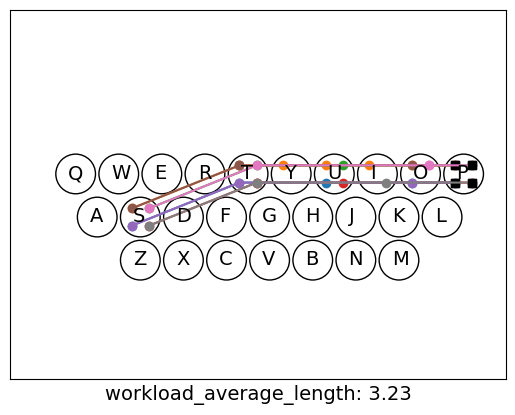

In [53]:
PWORDS = ['POUTS', 'POIUYTS', 'PUTS', 'PUTTS', 'POTS', 'POTTS', 'POOTS', 'PITS']
plot_with_paths(QWERTY, paths=PWORDS)